# Hyperlinks' clickability preferences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.parse
import seaborn as sns

In [2]:
import os, sys

# HTLM files URLs in a list 
wp_path = "/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wpcd/wp/" # to adapt
directories = os.listdir(wp_path)
html_list = []
for dir in directories:
    local_path = wp_path + dir
    local_dir = os.listdir(local_path)
    for link in local_dir:
        if link[-3:]=='htm':
            html_list.append(dir+'/'+link)
html_list[:10]

['r/Royal_Marines.htm',
 'r/Recycling.htm',
 'r/Retreat_of_glaciers_since_1850.htm',
 'r/Remember_Girls_Like_Rajpura.htm',
 'r/Rutherfordium.htm',
 'r/Rule_of_St_Benedict.htm',
 'r/Red_dwarf.htm',
 'r/Romeo_and_Juliet.htm',
 'r/Rudyard_Kipling.htm',
 'r/Race.htm']

## Objective

The aim of this specific section of our game strategy analysis is to test whether Wikispeedia players have clikability preferences on the basis of the hyperlinks' positioning throughout the article text. 
In particular:
1. we wil find the ordinal number of the paragraph each hyperlink in an article shows up in and divide it by the total number of paragraphs of the article, to determine its positioning; 
2. we will determine if each hyperlink in an article shows up in an image caption.

We will then investigate if there is a correlation between the clickability of the hyperlinks and their location, using the proper statistical tests. 

### Hyperlinks positioning in articles' text

It is essential to extract from the data the frequency of clicks for each hyperlink.

In [3]:
# read files 
folder='/Users/ginevralarroux/Desktop/EPFL courses/Applied data analysis/ADA project/data/wikispeedia_paths-and-graph/'

paths_finished='paths_finished.tsv'
paths_unfinished='paths_unfinished.tsv'
articles='articles.tsv'

paths_finished=pd.read_csv(folder+paths_finished, sep='\t', skiprows=15, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished=pd.read_csv(folder+paths_unfinished, sep='\t', skiprows=16, header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
articles=pd.read_csv(folder+articles, sep='\t', skiprows=12, header=None, names=['article'])

The dataframe `paths_finished` contains the paths chosen by the players who could reach the target article.

In [4]:
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


The dataframe `paths_unfinished` contains the paths chosen by the players who could not reach the target article.

In [5]:
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


The dataframe `articles` lists all the clickable articles/links.

In [6]:
# encode and filter link names
def filter_link(link):
    link=urllib.parse.unquote(link)
    link=link.lower()
    link=link.replace('_', ' ')
    link=link.strip()
    return link

articles.article=articles.article.apply(filter_link)
articles.head(10)

,article
0,áedán mac gabráin
1,åland
2,édouard manet
3,éire
4,óengus i of the picts
5,€2 commemorative coins
6,10th century
7,11th century
8,12th century
9,13th century


In [7]:
print('The total number of articles comprising the Wikispeedia library is {0}.'.format(len(articles)))

The total number of articles comprising the Wikispeedia library is 4604.


The dataframe `clicked_links_filtered` contains the clicked links troughout the paths.

In [8]:
def get_clicked_links(paths_df):
    clicked_links=[]
    removed_idxs=[]
    for idx, path in enumerate(paths_df['path']): 
        links_list=(path.split(';'))# get list of links along the path string 
        links_list_uncoded=[filter_link(link) for link in links_list]
        if (len(links_list_uncoded)) <= 1 or ('<' in links_list_uncoded):
            removed_idxs.append(idx)
            continue
        else:
            clicked_links.append(links_list_uncoded)
    return clicked_links, removed_idxs

clicked_links_filtered_f, removed_f=get_clicked_links(paths_finished) #f for paths_finished
clicked_links_filtered_u, removed_u=get_clicked_links(paths_unfinished) #u for paths_unfinished
clicked_links_filtered_f[:5]

[['14th century',
  '15th century',
  '16th century',
  'pacific ocean',
  'atlantic ocean',
  'accra',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'europe',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century',
  'niger',
  'nigeria',
  'british empire',
  'slavery',
  'africa',
  'atlantic slave trade',
  'african slave trade'],
 ['14th century', 'renaissance', 'ancient greece', 'greece'],
 ['14th century',
  'italy',
  'roman catholic church',
  'hiv',
  'ronald reagan',
  'president of the united states',
  'john f. kennedy']]

In [9]:
print('W.r.t the succesfull players dataframe, a total number of {0} paths are kept, out of {1}: {2} were discarded.'.format(len(clicked_links_filtered_f), len(removed_f)+len(clicked_links_filtered_f), len(removed_f))) 
##need to comment why do that

W.r.t the succesfull players dataframe, a total number of 42312 paths are kept, out of 51318: 9006 were discarded.


In [10]:
print('W.r.t the unsuccesfull players dataframe, a total number of {0} paths are kept, out of {1}: {2} were discarded.'.format(len(clicked_links_filtered_u),len(clicked_links_filtered_u)+len(removed_u),\
                                                                                                                               len(removed_u)))


W.r.t the unsuccesfull players dataframe, a total number of 14460 paths are kept, out of 24875: 10415 were discarded.


The dataframe `links_freq_df` contains the links' frequency of clicks.

In [11]:
def get_clicks_frequency(paths_list):
    
    links_name=[]
    links_freq=[]

    for article in articles['article']: # count the number of times each article shows up in paths
        count=0
        links_name.append(article)
        for path in range(len(paths_list)):
            if article in paths_list[path]:
                count+=paths_list[path].count(article)
        links_freq.append(count)

    links_freq_df=pd.concat([pd.Series(links_name), pd.Series(links_freq)], axis=1)
    links_freq_df.columns=['link', '#_clicks']
    return links_freq_df

links_freq_df_f=get_clicks_frequency(clicked_links_filtered_f)
links_freq_df_u=get_clicks_frequency(clicked_links_filtered_u)

links_freq_df_f.loc[links_freq_df_f['#_clicks']!=0].head()

,link,#_clicks
1,åland,1
2,édouard manet,1
3,éire,1
5,€2 commemorative coins,1
6,10th century,66


In [12]:
clicks_tot_f=links_freq_df_f['#_clicks'].sum()
clicks_tot_u=links_freq_df_u['#_clicks'].sum()
print('The total number of clicked hyperlinks by succesfull players is {0}.'.format(clicks_tot_f))
print('The total number of clicked hyperlinks by unsuccesfull players is {0}.'.format(clicks_tot_u))

The total number of clicked hyperlinks by succesfull players is 242257.
The total number of clicked hyperlinks by unsuccesfull players is 68711.


Next step of the descriptive analysis process is the html files parsing aimed at determining the location of hyperlinks. 

In [13]:
# parse html files 

from bs4 import BeautifulSoup

soups=[]
failed_html_list = []
for html in html_list[:]:
    f=open(wp_path+html, 'r')
    try:
        soup = BeautifulSoup(f, 'lxml')
        soups.append(soup)
    except Exception:
        failed_html_list.append(html)

In [14]:
print('{0} files were not parsable. However, they are not reachable nor it is possible to click \
any hyperlink in those html pages.'.format(len(failed_html_list)))

53 files were not parsable. However, they are not reachable nor it is possible to click any hyperlink in those html pages.


`link_positioning_dfs` is a list of dataframes (`link_positioning_df`) containing hyperlinks showing up in one html file, the ordinal number of the paragraph they belong to and their relative positioning throughout the article text. 

In [15]:
# HTML tag for hyperlinks is <a href= >
# the function finds all <a href= > tags throughout the article html file

def find_links(soup): 
    paragraphs = soup.find_all('p') 
    links=[]
    i=0
    for p in paragraphs:
        i+=1
        all_links=p.find_all('a')
        for link in all_links:
            if 'href' in link.attrs:
                link_title=link.text
                link_paragraph=i
                links.append([link_title, link_paragraph])
                
    link_positioning_df=pd.DataFrame(links, columns=['link', '#_paragraph']).drop_duplicates()
    link_positioning_df['positioning']=round(link_positioning_df['#_paragraph']/len(paragraphs), 2)
    link_positioning_df['link']=link_positioning_df['link'].apply(filter_link)
    return link_positioning_df

In [16]:
# apply the function to all html files

link_positioning_dfs=[]
for soup in soups:
    link_positioning_dfs.append(find_links(soup))

link_positioning_dfs[:5]

[                              link  #_paragraph  positioning
 0                       royal navy            1         0.01
 1                   united kingdom            1         0.01
 2                         cold war           18         0.19
 3                     sierra leone           20         0.21
 4                         dartmoor           24         0.25
 5                     world war ii           29         0.30
 6                         plymouth           34         0.35
 7                         scotland           34         0.35
 8                        gibraltar           43         0.44
 9                             cuba           44         0.45
 10               george washington           44         0.45
 11                      royal navy           45         0.46
 13                      portsmouth           46         0.47
 14                        plymouth           46         0.47
 15      american revolutionary war           46         0.47
 16     

In [17]:
print('{0} html files were parsed.'.format(len(link_positioning_dfs)))

5409 html files were parsed.


In [18]:
# example with 2 files

URL_1 = wp_path+'a/A_cappella.htm'
URL_2 = wp_path+'m/Music.htm'

f1=open(URL_1, 'r')
soup1 = BeautifulSoup(f1, 'lxml')

f2=open(URL_2, 'r')
soup2 = BeautifulSoup(f2, 'lxml')

link_positioning_df_1=find_links(soup1).drop(labels='#_paragraph', axis=1)
link_positioning_df_2=find_links(soup2).drop(labels='#_paragraph', axis=1)

# merging the 2 dataframes 

merged_dfs=link_positioning_df_1.merge(link_positioning_df_2, how='outer', left_on='link', right_on='link', )
merged_dfs

,link,positioning_x,positioning_y
0,music,0.04,NaN
1,instrumental,0.04,NaN
2,renaissance,0.04,NaN
3,renaissance,0.12,NaN
4,gregorian chant,0.12,NaN
5,amish,0.21,NaN
6,eastern orthodox,0.21,NaN
7,jewish,0.33,NaN
8,beatles,0.75,NaN
9,hindi,0.88,NaN


The hyperlink _rap_ shows up in both articles; the hyperlink _jazz_, _renaissance_ and _time_ show up multiple times in one article. 

The two occurrences highlighted are likely to be the case for every hyperlink, when all dataframes will be merged. It is therefore essential to compute their most likely positioning in the articles' texts, so to extract any meaningful information from the data.  

In [19]:
# merge all the link_positioning_df in link_positioning_dfs list on hyperlink in order to apply a function 
# that determines the most frequent positioning of the hyperlinks

link_positioning_dfs_grouped=[]

fail=0  
for i, df in enumerate(link_positioning_dfs):
    try:
        df=df.set_index("link")
        df=df["positioning"].groupby("link").apply(lambda x: x.values).rename(f"article_{i}")
        link_positioning_dfs_grouped.append(df)
    except:
        fail+=1
        pass 

from itertools import chain
link_positioning_concatenated=(pd.concat(link_positioning_dfs_grouped)
                               .groupby("link")
                               .apply(lambda x: list(chain(*x.values))))
link_positioning_concatenated[:10]

link
                                [0.78, 0.8, 0.84, 0.85, 0.87, 0.89, 0.91, 0.93...
"6 villages for 2006                                                       [0.67]
"6 villages for 2006"                                                [0.36, 0.46]
"capitalist rule"                                                          [0.16]
"consumption" (tuberculosis)                                               [0.03]
"glorious revolution"                                                      [0.39]
"grave"                                                                    [0.31]
"law of queen anne"                                                        [0.52]
"name and anagram"                                                          [0.1]
"nostalgic tram" no. 91                                                    [0.76]
dtype: object

In [20]:
# function that determines the most frequent positioning of each hyperlink in the set of all links

def find_positioning(array):
    bin_labels=['top', 'center-top','center','center-bottom', 'bottom'] # positioning is classified as top, centre-top, center, center-bottom, or bottom of the article
    bins=[0, 0.20, 0.40, 0.60, 0.80, 1] 
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning) # frequency of the bins
    most=positioning_frequency.apply('max') # bin with highest frequency
    if len(positioning_frequency[positioning_frequency==most])>1:
        return np.random.choice(positioning_frequency[positioning_frequency==most].index.values.astype(str)) #account for same frequency
    else:
        return positioning_frequency[positioning_frequency==most].index.values.astype(str).item()

The dataframe `most_freq_positioning_df` contains the hyperlinks' most frequent positioning.

In [21]:
# all html files

most_freq_positioning=link_positioning_concatenated.apply(find_positioning)
most_freq_positioning_df=pd.DataFrame(most_freq_positioning, columns=['most_freq_positioning'])
most_freq_positioning_df.reset_index(inplace=True)
most_freq_positioning_df.head()

,link,most_freq_positioning
0,,bottom
1,"""6 villages for 2006",center-bottom
2,"""6 villages for 2006""",center
3,"""capitalist rule""",top
4,"""consumption"" (tuberculosis)",top


The dataframe `links_freq_pos` contains both the hyperlinks' most frequent positioning and their frequency of clicks.

In [22]:
links_freq_pos_f=links_freq_df_f.merge(most_freq_positioning_df, how='outer', left_on='link', right_on='link')
links_freq_pos_u=links_freq_df_u.merge(most_freq_positioning_df, how='outer', left_on='link', right_on='link')
links_freq_pos_f.head()

,link,#_clicks,most_freq_positioning
0,áedán mac gabráin,0.0,top
1,åland,1.0,bottom
2,édouard manet,1.0,center-bottom
3,éire,1.0,top
4,óengus i of the picts,0.0,NaN


In [23]:
print('In {0} out of {1} cases clicked links by players don\'t have a most frequent positioning as they do not show up \
in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.'\
      .format((links_freq_pos_f['most_freq_positioning'].isna()).sum(), len(links_freq_pos_f)))

In 987 out of 11520 cases clicked links by players don't have a most frequent positioning as they do not show up in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.


In [24]:
print('In {0} out of {1} cases clicked links by players don\'t have a most frequent positioning as they do not show up \
in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.'\
      .format((links_freq_pos_u['most_freq_positioning'].isna()).sum(), len(links_freq_pos_u)))

In 987 out of 11520 cases clicked links by players don't have a most frequent positioning as they do not show up in the dataframe containing hyperlinks in HTML pages. They are replaced with random values.


In [25]:
links_freq_pos_f['most_freq_positioning'].\
fillna(np.random.choice(['top', 'center-top','center','center-bottom', 'bottom']),inplace=True)
links_freq_pos_u['most_freq_positioning'].\
fillna(np.random.choice(['top', 'center-top','center','center-bottom', 'bottom']),inplace=True)                                           

In [26]:
links_freq_pos_f['#_clicks'].fillna(0,inplace=True) #count NaN as 0 frequency
links_freq_pos_u['#_clicks'].fillna(0,inplace=True)
not_clicked_f=(links_freq_pos_f['#_clicks']==0).sum() #null #_clicks
not_clicked_u=(links_freq_pos_u['#_clicks']==0).sum()
print('There are {0} links in the articles, {1} never clicked by succesful players.'.format(len(most_freq_positioning_df), not_clicked_f))
print('There are {0} links in the articles, {1} never clicked by unsuccesful players.'.format(len(most_freq_positioning_df), not_clicked_u))

There are 10533 links in the articles, 7364 never clicked by succesful players.
There are 10533 links in the articles, 7617 never clicked by unsuccesful players.


In [27]:
print('In respectively {0}, {1} cases the number of clicks per link between successful and unsuccesful players is equal, not equal.'\
      .format((links_freq_pos_f['#_clicks']==links_freq_pos_u['#_clicks']).sum(), 
      (links_freq_pos_f['#_clicks']!=links_freq_pos_u['#_clicks']).sum()))

In respectively 7416, 4104 cases the number of clicks per link between successful and unsuccesful players is equal, not equal.


In [28]:
# problem!!!

The dataframe `links_freq_pos_grouped_df` groups the hyperlinks click frequency by their positioning.

In [29]:
links_freq_pos_grouped_f=pd.DataFrame(links_freq_pos_f['#_clicks'].groupby(links_freq_pos_f['most_freq_positioning']).sum())
links_freq_pos_grouped_f['#_clicks_norm']=links_freq_pos_grouped_f['#_clicks']/clicks_tot_f #normalization

links_freq_pos_grouped_u=pd.DataFrame(links_freq_pos_u['#_clicks'].groupby(links_freq_pos_u['most_freq_positioning']).sum())
links_freq_pos_grouped_u['#_clicks_norm']=links_freq_pos_grouped_u['#_clicks']/clicks_tot_u #normalization

links_freq_pos_grouped_f

,#_clicks,#_clicks_norm
most_freq_positioning,,
bottom,32454.0,0.133965
center,12026.0,0.049641
center-bottom,15389.0,0.063523
center-top,18978.0,0.078338
top,163410.0,0.674532


In [30]:
links_freq_pos_grouped_u

,#_clicks,#_clicks_norm
most_freq_positioning,,
bottom,7169.0,0.104336
center,3076.0,0.044767
center-bottom,6403.0,0.093187
center-top,4851.0,0.070600
top,47212.0,0.687110


In order to compare the hyperlinks click frequencies with regard to their positioning (i.e. _top_, _center-top_, _center_, _center-bottom_, _bottom_) their absolute values need to be normalized with the bins' frequencies (i.e. the number of times the hypelinks actually show up in the categorical positioning).

The dataframe `positioning_freq_df_grouped` contains the frequency of hyperlinks showing up in the Wikispeedia set of articles grouped by their positioning throughout the text. 

In [31]:
# function that counts the frequency of a link showing up at the top, center, bottom of the article

def find_positioning_dis(array):
    bin_labels=['top', 'center-top','center', 'center-bottom', 'bottom']
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1]
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning)
    return positioning_frequency

In [32]:
# apply the function to the dataframe links positioning grouped by link  

positioning_freq=link_positioning_concatenated.apply(find_positioning_dis)
positioning_freq

,bottom,top,center-bottom,center,center-top
link,,,,,
,220,130,45,42,33
"""6 villages for 2006",0,0,1,0,0
"""6 villages for 2006""",0,0,0,1,1
"""capitalist rule""",0,1,0,0,0
"""consumption"" (tuberculosis)",0,1,0,0,0
...,...,...,...,...,...
‘6 villages for 2006’,0,0,1,0,1
“6 villages for 2006”,0,0,0,1,0
€,2,2,6,3,4


In [33]:
positioning_freq_grouped=pd.DataFrame(positioning_freq.sum(axis=0), columns=['nr']) # group by positioning

links_tot=positioning_freq_grouped['nr'].sum()
positioning_freq_grouped['nr_norm']=positioning_freq_grouped['nr']/links_tot
positioning_freq_grouped

,nr,nr_norm
bottom,24193,0.184871
top,40824,0.311957
center-bottom,22588,0.172607
center,20228,0.154573
center-top,23031,0.175992


In [34]:
# dataframe for visualization

vis_f=links_freq_pos_grouped_f.merge(positioning_freq_grouped, left_index=True, right_index=True)
vis_u=links_freq_pos_grouped_u.merge(positioning_freq_grouped, left_index=True, right_index=True)
vis_f

,#_clicks,#_clicks_norm,nr,nr_norm
bottom,32454.0,0.133965,24193,0.184871
center,12026.0,0.049641,20228,0.154573
center-bottom,15389.0,0.063523,22588,0.172607
center-top,18978.0,0.078338,23031,0.175992
top,163410.0,0.674532,40824,0.311957


In [35]:
vis_u

,#_clicks,#_clicks_norm,nr,nr_norm
bottom,7169.0,0.104336,24193,0.184871
center,3076.0,0.044767,20228,0.154573
center-bottom,6403.0,0.093187,22588,0.172607
center-top,4851.0,0.070600,23031,0.175992
top,47212.0,0.687110,40824,0.311957


In [36]:
vis_f['clicked']=vis_f['#_clicks_norm']/vis_f['nr_norm']
vis_u['clicked']=vis_u['#_clicks_norm']/vis_u['nr_norm']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '#_clicks / #_hyperlinks')

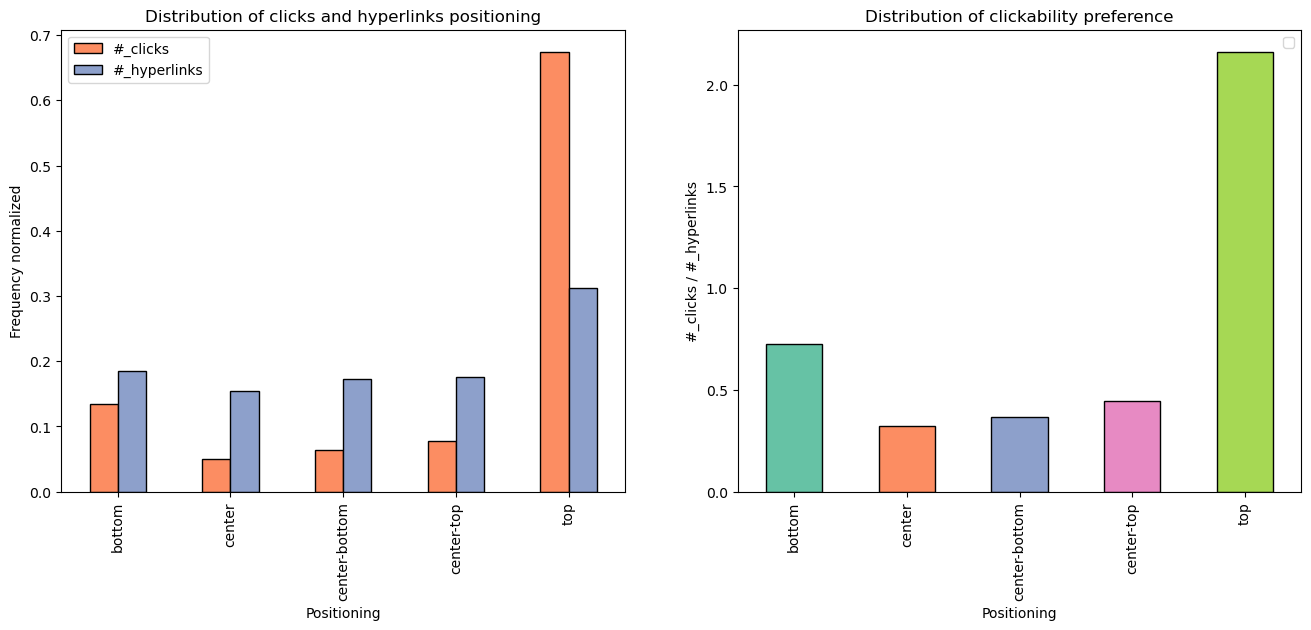

In [37]:
# visualization of the distribution of the clicked hyperlinks' positioning

fig, ax = plt.subplots(1,2, figsize=(16,6))

colors=sns.color_palette("Set2")


vis_f.plot(y=['#_clicks_norm', 'nr_norm'], kind='bar', ax=ax[0], label=['#_clicks', '#_hyperlinks'], color=colors[1:3], edgecolor='k')
ax[0].legend()
ax[0].set_title('Distribution of clicks and hyperlinks positioning')
ax[0].set_xlabel('Positioning')
ax[0].set_ylabel('Frequency normalized')

vis_f.plot(y='clicked', kind='bar', ax=ax[1], label='', color=colors, edgecolor='k')
ax[1].legend()
ax[1].set_title('Distribution of clickability preference')
ax[1].set_xlabel('Positioning')
ax[1].set_ylabel('#_clicks / #_hyperlinks')

In [38]:
colors=sns.color_palette("Set2")
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '#_clicks / #_hyperlinks')

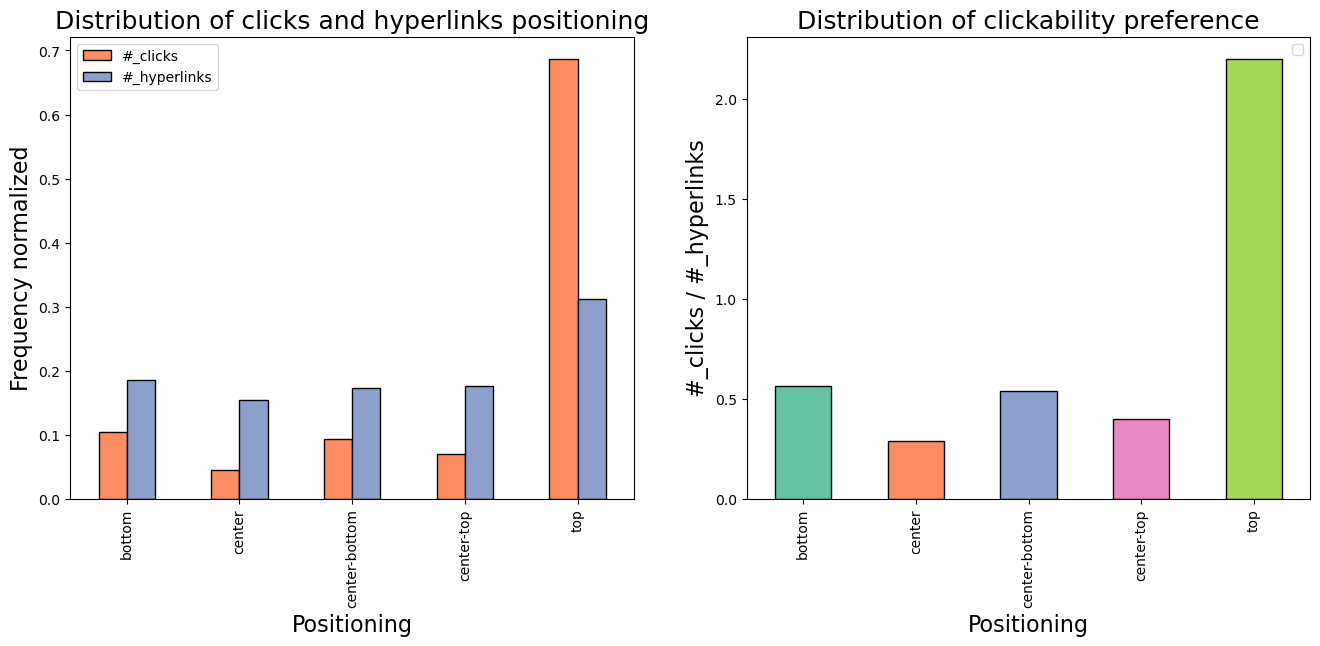

In [39]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

colors=sns.color_palette("Set2")

vis_u.plot(y=['#_clicks_norm', 'nr_norm'], kind='bar', ax=ax[0], label=['#_clicks', '#_hyperlinks'], color=colors[1:3], edgecolor='k')
ax[0].legend()
ax[0].set_title('Distribution of clicks and hyperlinks positioning', fontsize=18)
ax[0].set_xlabel('Positioning', fontsize=16)
ax[0].set_ylabel('Frequency normalized', fontsize=16)

vis_u.plot(y='clicked', kind='bar', ax=ax[1], label='', color=colors, edgecolor='k')
ax[1].legend()
ax[1].set_title('Distribution of clickability preference', fontsize=18)
ax[1].set_xlabel('Positioning', fontsize=16)
ax[1].set_ylabel('#_clicks / #_hyperlinks', fontsize=16)

The bar plot on the left illustrates the distribution of the clicked hyperlinks and the total number of links in the articles, on the basis of their positioning throughout the articles text, both normalized. 

The bar plot on the right illustrates the hyperlinks clickability on the basis of their positioning. More precisely: 
1. a value of 1 (_\#_clicks_/_\#_hyperlinks_ = 1) corresponds to a hyperlinks clickability on average equally proportional to the normalized frequency of the specific categorical positioning (i.e. the number of clicks proportional to the number times a hyperlink shows up in a section of the article);
2. a value of greater than 1, points a more than proportional clickability;
3. a value of smaller than 1, points a less than proportional clickability.

In [40]:
vis_f['success']=1
vis_u['success']=0
vis=pd.concat([vis_f,vis_u], axis=0)
vis

,#_clicks,#_clicks_norm,nr,nr_norm,clicked,success
bottom,32454.0,0.133965,24193,0.184871,0.724640,1
center,12026.0,0.049641,20228,0.154573,0.321153,1
center-bottom,15389.0,0.063523,22588,0.172607,0.368024,1
center-top,18978.0,0.078338,23031,0.175992,0.445125,1
top,163410.0,0.674532,40824,0.311957,2.162255,1
bottom,7169.0,0.104336,24193,0.184871,0.564369,0
center,3076.0,0.044767,20228,0.154573,0.289619,0
center-bottom,6403.0,0.093187,22588,0.172607,0.539883,0
center-top,4851.0,0.070600,23031,0.175992,0.401155,0
top,47212.0,0.687110,40824,0.311957,2.202575,0


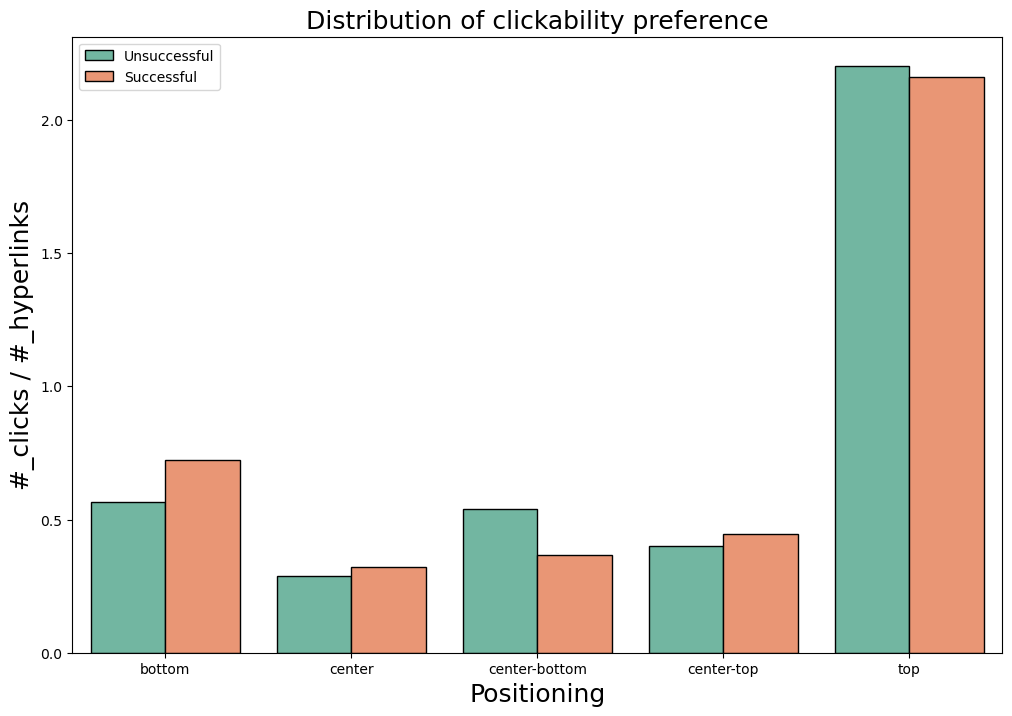

In [41]:
fig, ax = plt.subplots(figsize=(12,8), sharey=True)

sns.barplot(y='clicked', x=vis.index, data=vis, palette=sns.color_palette("Set2"), hue='success', edgecolor='k')

ax.set_title('Distribution of clickability preference', fontsize=18)
ax.set_xlabel('Positioning', fontsize=18)
ax.set_ylabel('#_clicks / #_hyperlinks', fontsize=18)
ax.legend_.set_title('')
labels = ['Unsuccessful', 'Successful']
for t, l in zip(ax.legend_.texts, labels):
    t.set_text(l)

There is an evident players' clickability preference for hyperlinks showing up at the top of articles, followed by a preference for bottom and center-bottom positionings. <br>
The highest gap between successful and unsuccessful players is for hyperlinks in the center-bottom of articles: successful players click on average more on center-bottom-positioned links than unsuccesful ones. The trend is reversed for top-positioned links. 
Center-positioned links are clicked the least, both by successful and unsuccessful players. 

In [42]:
vis_f

,#_clicks,#_clicks_norm,nr,nr_norm,clicked,success
bottom,32454.0,0.133965,24193,0.184871,0.724640,1
center,12026.0,0.049641,20228,0.154573,0.321153,1
center-bottom,15389.0,0.063523,22588,0.172607,0.368024,1
center-top,18978.0,0.078338,23031,0.175992,0.445125,1
top,163410.0,0.674532,40824,0.311957,2.162255,1


In [43]:
vis_u

,#_clicks,#_clicks_norm,nr,nr_norm,clicked,success
bottom,7169.0,0.104336,24193,0.184871,0.564369,0
center,3076.0,0.044767,20228,0.154573,0.289619,0
center-bottom,6403.0,0.093187,22588,0.172607,0.539883,0
center-top,4851.0,0.070600,23031,0.175992,0.401155,0
top,47212.0,0.687110,40824,0.311957,2.202575,0


### Hyperlinks positioning in images' caption

The following part of the descriptive analysis focuses on the location of hyperlinks in images' captions.

Images in html files can be either found under \<div> or \<table> tag, while the hyperlinks are found in their captions under \<div class='thumbcaption'> tag.

The dataframe `links_in_tables` contains the links showing up in tables' captions. 

In [44]:
# parse html file and search hyperlinks in the captions of tables containing images 

def find_link_in_table(soup):
    
    tables = soup.find_all('table')

    links=[]
    for table in tables:
        if table.find('img'):
            all_links=table.find_all('a')
            for link in all_links:
                if 'class' not in link.attrs:
                    link_title=link.text
                    links.append(link_title)

    if links:
        links_in_table_df=pd.DataFrame(links).drop_duplicates()
        links_in_table_df.columns=['link']
        links_in_table_df['link']=links_in_table_df['link'].apply(filter_link) 
    else: 
        return None
    return links_in_table_df

In [45]:
links_in_tables=[]
for soup in soups:
    links_in_tables.append(find_link_in_table(soup))

links_in_tables_df=pd.concat(links_in_tables, axis=0)
links_in_tables_df.head()

,link
0,royal navy
1,united kingdom
3,plymouth
4,latin
0,lawrencium


In [46]:
links_in_tables_tot=len(links_in_tables_df)
print('The total number of links in tables captions is {0}.'.format(links_in_tables_tot))

The total number of links in tables captions is 15159.


The dataframe `links_in_images` contains the links showing up in images' captions.

In [47]:
# parse html file and search hyperlinks in the captions of div containing images 

def find_links_in_img(soup):
    div = soup.find_all('div')

    links=[]

    for d in div:
        if (d.find('a', class_="internal")):
            if (d.find('img', class_='thumbimage')):
                caption=d.find('div', class_="thumbcaption")
                if (caption.find('a')):
                    all_links=caption.find_all('a')
                    for link in all_links:
                        if 'class' not in link.attrs:
                            link_title=link.text
                            links.append(link_title)
    if links:
        links_in_image_df=pd.DataFrame(links).drop_duplicates()
        links_in_image_df.columns=['link']
        links_in_image_df['link']=links_in_image_df['link'].apply(filter_link) 
    else: 
        return None
        links_in_image_df=pd.DataFrame()
    return links_in_image_df

In [48]:
links_in_images=[]
for soup in soups:
    links_in_images.append(find_links_in_img(soup))


links_in_images_df=pd.concat(links_in_images, axis=0)
links_in_images_df.head()

,link
0,bangladesh
0,portsmouth
2,england
4,india
0,pompeii


In [49]:
links_in_images_tot=len(links_in_images_df)
print('The total number of links in images captions is {0}.'.format(links_in_images_tot))

The total number of links in images captions is 372.


Next, the supposed clickability preference for a hyperlink showing up in an image will be investigated, by grouping the click frequency by hyperlinks' location.

In [50]:
# drop indexes to ease the flagging
links_in_images_df=links_in_images_df.reset_index(drop=True)
links_in_tables_df=links_in_tables_df.reset_index(drop=True)

The dataframe `links_freq_img` contains hyperlinks click frequency and a flag specifying if they can be found in images' captions.

In [51]:
# link in image

links_freq_img_f=links_freq_df_f.copy()
links_freq_img_u=links_freq_df_u.copy()

links_freq_img_f['in_image']=[1 if link in list(links_in_images_df['link']) else 0
                           for link in links_freq_img_f['link']]
links_freq_img_u['in_image']=[1 if link in list(links_in_images_df['link']) else 0
                           for link in links_freq_img_u['link']]

The dataframe `links_freq_tab` contains hyperlinks click frequency and a flag specifying if they can be found in tables' captions.

In [52]:
# link in table

links_freq_tab_f=links_freq_df_f.copy()
links_freq_tab_u=links_freq_df_u.copy()

links_freq_tab_f['in_tab']=[1 if link in list(links_in_tables_df['link']) else 0
                           for link in links_freq_tab_f['link']]
links_freq_tab_u['in_tab']=[1 if link in list(links_in_tables_df['link']) else 0
                               for link in links_freq_tab_u['link']]

In [53]:
# find normalized values of clicks (#_clicks) on the basis of the relative number of times a hyperlink shows up in an 
# image caption to occurrence in the article text 

# images 

links_in_img=pd.concat(links_in_images, axis=0).reset_index(drop=True)

link_in_img_freq_df=pd.DataFrame(links_in_img['link'].value_counts()).reset_index()
link_in_img_freq_df.columns=['link', '#_link_in_img']
link_in_img_freq_df

,link,#_link_in_img
0,london,10
1,george w. bush,5
2,leonardo da vinci,4
3,united states,4
4,greece,4
...,...,...
277,granite,1
278,airbus a380,1
279,lunar,1
280,peregrine falcon,1


In [54]:
# links showing up in articles

link_in_article=pd.concat(link_positioning_dfs, axis=0)['link']

link_in_article_freq_df=pd.DataFrame(link_in_article.value_counts()).reset_index()
link_in_article_freq_df.columns=['link', '#_link_in_article']
link_in_article_freq_df

,link,#_link_in_article
0,united states,1492
1,france,863
2,world war ii,862
3,europe,780
4,united kingdom,719
...,...,...
10530,carolingians,1
10531,convent,1
10532,monastic,1
10533,banaras,1


In [55]:
df_img_f=pd.merge(links_freq_img_f, link_in_img_freq_df, how='left', left_on='link', right_on='link')
new_df_img_f=pd.merge(df_img_f, link_in_article_freq_df, how='left', left_on='link', right_on='link')

new_df_img_f['#_clicks'].fillna(0, inplace=True)
new_df_img_f['in_image'].fillna(1, inplace=True)
new_df_img_f['#_link_in_img'].fillna(0, inplace=True) 

new_df_img_f

,link,#_clicks,in_image,#_link_in_img,#_link_in_article
0,áedán mac gabráin,0,0,0.0,2.0
1,åland,1,1,1.0,4.0
2,édouard manet,1,1,1.0,10.0
3,éire,1,0,0.0,3.0
4,óengus i of the picts,0,0,0.0,NaN
...,...,...,...,...,...
4599,zionism,16,0,0.0,21.0
4600,zirconium,25,0,0.0,11.0
4601,zoroaster,12,0,0.0,5.0
4602,zuid-gelders,4,0,0.0,3.0


In [56]:
df_img_u=pd.merge(links_freq_img_u, link_in_img_freq_df, how='left', left_on='link', right_on='link')
new_df_img_u=pd.merge(df_img_u, link_in_article_freq_df, how='left', left_on='link', right_on='link')

new_df_img_u['#_clicks'].fillna(0, inplace=True)
new_df_img_u['in_image'].fillna(1, inplace=True)
new_df_img_u['#_link_in_img'].fillna(0, inplace=True) 

In [57]:
norm_values_img_f=new_df_img_f.loc[new_df_img_f['in_image']==1,'#_link_in_img']/new_df_img_f.loc[new_df_img_f['in_image']==1,'#_link_in_article'] #link in text counts also the clicks in images captions
clicks_norm_img_f=(new_df_img_f['#_clicks']*norm_values_img_f)
clicks_norm_img_f.fillna(1, inplace=True)

links_freq_img_f_norm=links_freq_img_f.copy()
links_freq_img_f_norm.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_img_f_norm['#_clicks_norm']=clicks_norm_img_f
links_freq_img_f_norm

,link,#_clicks_norm,in_image
0,áedán mac gabráin,1.00,0
1,åland,0.25,1
2,édouard manet,0.10,1
3,éire,1.00,0
4,óengus i of the picts,1.00,0
...,...,...,...
4599,zionism,1.00,0
4600,zirconium,1.00,0
4601,zoroaster,1.00,0
4602,zuid-gelders,1.00,0


In [58]:
norm_values_img_u=new_df_img_u.loc[new_df_img_u['in_image']==1,'#_link_in_img']/new_df_img_u.loc[new_df_img_u['in_image']==1,'#_link_in_article'] #link in text counts also the clicks in images captions
clicks_norm_img_u=(new_df_img_u['#_clicks']*norm_values_img_u)
clicks_norm_img_u.fillna(1, inplace=True)

links_freq_img_u_norm=links_freq_img_u.copy()
links_freq_img_u_norm.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_img_u_norm['#_clicks_norm']=clicks_norm_img_u

In [59]:
# tables 

#links_in_tab=pd.concat(links_in_tables, axis=0).reset_index(drop=True)
#
#link_in_tab_freq=[]
#link_name=[]
#
#for link in list(links_in_tab['link']):
#    count=list(links_in_tab['link']).count(link)
#    link_name.append(link)
#    link_in_tab_freq.append(count)
#
#link_name=pd.Series(link_name)
#link_in_tab_freq=pd.Series(link_in_tab_freq)
#link_in_tab_freq_df=pd.concat([link_name, link_in_tab_freq], axis=1)
#link_in_tab_freq_df.columns=['link', '#_link_in_tab']

In [60]:
#links_in_text=pd.concat(link_positioning_dfs, axis=0)['link']
#link_in_text_freq=[]
#link_name=[]
#
#for link in list(links_in_tab['link']):
#    count=list(links_in_text).count(link)
#    link_name.append(link)
#    link_in_text_freq.append(count)
#
#link_name_text=pd.Series(link_name)
#link_in_text_freq=pd.Series(link_in_text_freq)
#link_in_text_freq_df=pd.concat([link_name_text, link_in_text_freq], axis=1)
#link_in_text_freq_df.columns=['link', '#_link_in_text']

In [61]:
#df_tab=pd.merge(links_freq_tab[links_freq_tab['in_tab']==1], link_in_tab_freq_df, left_on='link', right_on='link')
#new_df_tab=pd.merge(df_tab, link_in_text_freq_df, left_on='link', right_on='link')
#new_df_tab=new_df_tab.set_index('link')
#
#norm_values_tab=new_df_tab['#_link_in_tab']/new_df_tab['#_link_in_text']
#clicks_norm_tab=(new_df_tab['#_clicks']*norm_values_tab)
#clicks_norm_tab.replace([np.inf, -np.inf], np.nan, inplace=True)
#clicks_norm_tab=clicks_norm_tab.fillna(0).values.astype('int')
#
#links_freq_tab=links_freq_tab.set_index('link')
#links_freq_tab.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
#links_freq_tab.loc[norm_values_tab.index,'#_clicks_norm']=clicks_norm_tab
#links_freq_tab

The dataframe `links_freq_img_grouped_df` contains the frequency of clicks for hyperlinks showing up in images' captions and not, and their normalized values.

In [62]:
links_freq_img_grouped_df_f=pd.DataFrame(links_freq_img_f_norm['#_clicks_norm'].groupby(links_freq_img_f_norm['in_image']).sum())

links_freq_img_grouped_df_f.loc[0,'#_clicks/#_links_img']=links_freq_img_grouped_df_f.loc[0,'#_clicks_norm']/(links_tot-links_in_images_tot)
links_freq_img_grouped_df_f.loc[1,'#_clicks/#_links_img']=links_freq_img_grouped_df_f.loc[1,'#_clicks_norm']/links_in_images_tot

links_freq_img_grouped_df_f['success']=1
links_freq_img_grouped_df_f

,#_clicks_norm,#_clicks/#_links_img,success
in_image,,,
0,4388.000000,0.033627,1
1,661.134125,1.777242,1


In [63]:
links_freq_img_grouped_df_u=pd.DataFrame(links_freq_img_u_norm['#_clicks_norm'].groupby(links_freq_img_u_norm['in_image']).sum())

links_freq_img_grouped_df_u.loc[0,'#_clicks/#_links_img']=links_freq_img_grouped_df_u.loc[0,'#_clicks_norm']/(links_tot-links_in_images_tot)
links_freq_img_grouped_df_u.loc[1,'#_clicks/#_links_img']=links_freq_img_grouped_df_u.loc[1,'#_clicks_norm']/links_in_images_tot

links_freq_img_grouped_df_u['success']=0

The dataframe `links_freq_tab_grouped_df` contains the frequency of clicks for hyperlinks showing up in tables' captions and not, and their normalized values.

In [64]:
#links_freq_tab_grouped_df=pd.DataFrame(links_freq_tab['#_clicks_norm'].groupby(links_freq_tab['in_tab']).sum())
#
#links_freq_tab_grouped_df.loc[0,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[0,'#_clicks_norm']/(links_tot-links_in_tables_tot)
#links_freq_tab_grouped_df.loc[1,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[1,'#_clicks_norm']/links_in_tables_tot
#
#links_freq_tab_grouped_df

In [65]:
# dataframe for visualization
#vis_img=links_freq_img_grouped_df.merge(links_freq_tab_grouped_df, left_index=True, right_index=True)
#
#fig, ax = plt.subplots(figsize=(6,5))
#vis_img.plot(y=['#_clicks/#_links_img', '#_clicks/#_links_tab'], kind='bar', ax=ax, label=['image', 'table'], color=['orange', 'green'])
#ax.legend()
#ax.set_xlabel('Link in image or table caption')
#ax.set_ylabel('#_clicks/#_hyperlinks')
#ax.set_title('Distribution of hyperlinks in captions clickability preference')

In [66]:
# need comment

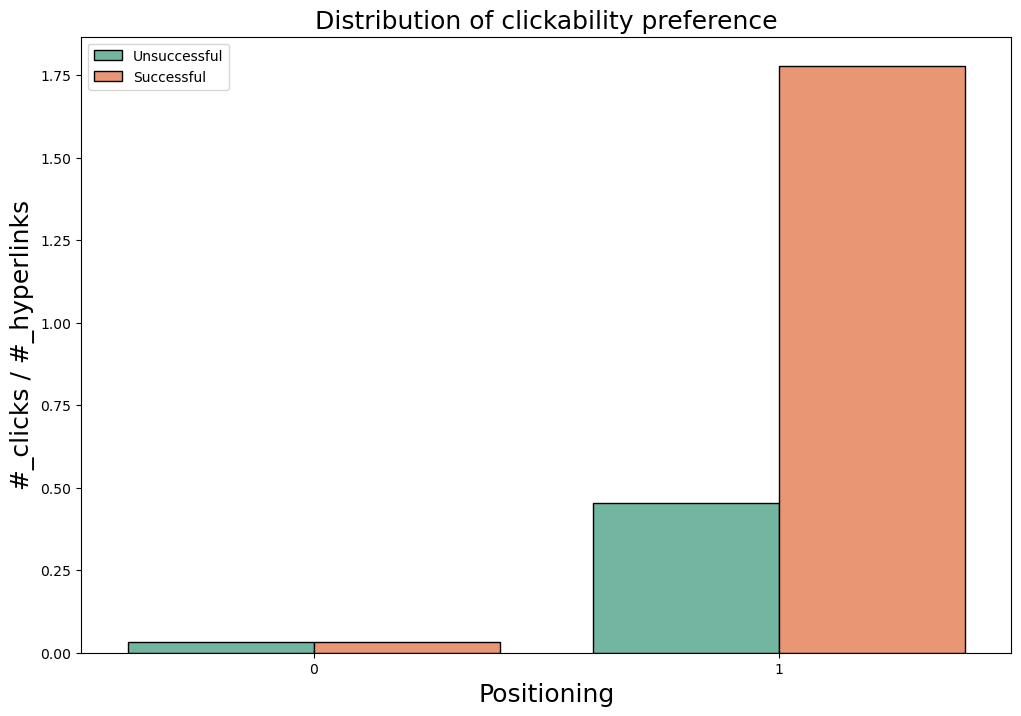

In [67]:
vis_img=pd.concat([links_freq_img_grouped_df_f, links_freq_img_grouped_df_u], axis=0)

fig, ax = plt.subplots(figsize=(12,8), sharey=True)

sns.barplot(y='#_clicks/#_links_img', x=vis_img.index, data=vis_img, palette=sns.color_palette("Set2"), hue='success', edgecolor='k')

ax.set_title('Distribution of clickability preference', fontsize=18)
ax.set_xlabel('Positioning', fontsize=18)
ax.set_ylabel('#_clicks / #_hyperlinks', fontsize=18)
ax.legend_.set_title('')
labels = ['Unsuccessful', 'Successful']
for t, l in zip(ax.legend_.texts, labels):
    t.set_text(l)

There is an evident players' clicability preference for hyperlinks showing up in images, both among successful and unsuccessful players. <br>
Moreover, succesfull players click on average more than unsuccessful ones.  

Assumptions: 
1. when a hyperlink shows up in both the article text and in an image caption, it is not possible to extract from the data in our possess what the player's click choice perfomed is. Therefore we assumed that hyperlinks showing up in images' captions don't appear in the text, as the following statement justifies. The normalization, therefore took into account a total number of links in texts equal to  (total number of hyperlinks detected) - (total number of hyperlinks showing up in images' captions). 

In [68]:
twice=0
for idx in range(len(link_positioning_dfs)):
    if links_in_images[idx] is None:
        continue
    else:
        if set(link_positioning_dfs[idx]['link']).intersection(set(links_in_images[idx]['link'])):
            twice+=1
print('{0} hyperlinks show up both in the text and in an image caption of an article, out of {1} articles.'.format(twice, len(link_positioning_dfs)))

93 hyperlinks show up both in the text and in an image caption of an article, out of 5409 articles.


## Regression analysis

In [69]:
path_lenghts_f=[len(path) for path in clicked_links_filtered_f]
path_lenghts_u=[len(path) for path in clicked_links_filtered_u]

In [70]:
def find_features(paths_list):
    features=[]
    for path in paths_list:
        features.append([most_freq_positioning_df.loc[link].values.item() 
                         if link in most_freq_positioning_df.index else np.random.choice(['top', 'center-top','center','center-bottom', 'bottom'])
                         for link in path])
    return features

In [71]:
## to discuss: 3% of links do not show up in most_freq_positioning_df

In [72]:
features_f=find_features(clicked_links_filtered_f)
features_u=find_features(clicked_links_filtered_u)

In [73]:
def find_features_frequency(features):
    t=[]
    ct=[]
    c=[]
    cb=[]
    b=[]    
    for path in features:
        t.append(path.count('top'))
        ct.append(path.count('center-top'))
        c.append(path.count('center'))
        cb.append(path.count('center-bottom'))
        b.append(path.count('bottom'))
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

features_frequency_f=find_features_frequency(features_f)
features_frequency_u=find_features_frequency(features_u)

In [74]:
def find_features_category(features):
    t=[]
    ct=[]
    c=[]
    cb=[]
    b=[]    
    for path in features:
        t.append(1 if 'top' in path else 0)
        ct.append(1 if 'center-top' in path else 0)
        c.append(1 if 'center' in path else 0)
        cb.append(1 if 'center-bottom' in path else 0)
        b.append(1 if 'bottom' in path else 0)
    return pd.DataFrame({'top': t, 'center_top': ct, 'center': c, 'center_bottom': cb, 'bottom': b})

features_categorical_f=find_features_category(features_f)
features_categorical_u=find_features_category(features_u)

In [75]:
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [76]:
reg_df_f=pd.concat([pd.Series(path_lenghts_f, name='pathlength'), features_frequency_f], axis=1)
reg_df_u=pd.concat([pd.Series(path_lenghts_u, name='pathlength'), features_frequency_u], axis=1)

In [77]:
#normalize features (e.g. #_top_links in path/len(path)) 

def norm_features(df):
    df_new=pd.DataFrame()
    for c in df.columns[1:]:
        df_new[c]=df[c]/df['pathlength']
    return df_new

#standardize features 

def standardize_features(df):
    df_std=pd.DataFrame()
    for c in df.columns:
        df_std[c]=(df[c]-df[c].mean())/df[c].std()
    return df_std

In [78]:
reg_df_norm_f=norm_features(reg_df_f).reset_index(drop=True)  
reg_df_norm_u=norm_features(reg_df_u).reset_index(drop=True)  

reg_df_norm_std_f=standardize_features(reg_df_norm_f)
reg_df_norm_std_u=standardize_features(reg_df_norm_u)

reg_df_norm_std_f['success']=1
reg_df_norm_std_u['success']=0

In [79]:
reg_df_norm_std_u=pd.concat([reg_df_norm_std_f, reg_df_norm_std_u], axis=0)

mod= smf.logit(formula='success ~ top + center_top + center + center_bottom + bottom', data=reg_df_norm_std_u)
res=mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.567443
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                56772
Model:                          Logit   Df Residuals:                    56766
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:               1.488e-12
Time:                        13:25:35   Log-Likelihood:                -32215.
converged:                       True   LL-Null:                       -32215.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0737      0.010    111.462      0.000       1.055       1.093
top            9.606

unitary p-values, all coefficients not significant

In [80]:
reg_C_df_f=pd.concat([pd.Series(path_lenghts_f, name='pathlength'), features_categorical_f], axis=1)
reg_C_df_u=pd.concat([pd.Series(path_lenghts_u, name='pathlength'), features_categorical_u], axis=1)

reg_C_df_f['success']=1
reg_C_df_u['success']=0

reg_C_df=pd.concat([reg_C_df_f, reg_C_df_u], axis=0)

mod_C_f = smf.logit(formula='success ~ C(top) + C(center_top) + C(center) + C(center_bottom) + C(bottom)', data=reg_C_df)
res_C_f=mod_C_f.fit()
print(res_C_f.summary())

Optimization terminated successfully.
         Current function value: 0.543714
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                56772
Model:                          Logit   Df Residuals:                    56766
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.04182
Time:                        13:25:36   Log-Likelihood:                -30868.
converged:                       True   LL-Null:                       -32215.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.6291      0.034    -18.378      0.000      -0.696      -0.

## Matched analysis

### Positioning

Get source, target article and the shortest path distance linking them in the Wikispeedia graph.

In [81]:
shortest_path_matrix = []

with open(folder+'shortest-path-distance-matrix.txt', 'r') as f:
    # the first 17 lines (indexed from 0) is the file description 
    for line in f.readlines()[17:]:
        shortest_path_matrix.append(line)

In [82]:
def get_shortest_path(paths_df: pd.DataFrame, successful: bool)-> pd.DataFrame:
    
    paths_list, removed_idxs=get_clicked_links(paths_df)
    
    pathlengths, source_articles, target_articles, shortest_paths = [], [], [], []
    
    articles_list=list(articles.article)
    
    def get_source_target(paths, successful):
        
        target_articles, shortest_paths = [], []
        
        for path in paths:

            pathlength=len(path)
            pathlengths.append(pathlength)

            source=path[0]
            source_articles.append(source)

            if successful:
                target=path[-1]
                target_articles.append(target)
        
        if not successful:
            target_articles=paths_df.drop(removed_idxs)['target'].apply(filter_link)
            
        return pathlengths, source_articles, target_articles
    
    pathlengths, source_articles, target_articles = get_source_target(paths_list, successful)
    
    for source, target in zip(source_articles, target_articles):
        
        source_index = articles_list.index(source)
        # there are target articles that were not provided in the plain text files
        try:
            target_index = articles_list.index(target)
        except Exception:
            shortest_paths.append("N/A")
            continue

        # query the shortest path matrix to get the correct vector (corresponding to the source article)
        shortest_path_vector = shortest_path_matrix[source_index]
        # now find the target article indexed integer in the vector
        shortest = shortest_path_vector[target_index]
        # it's not always possible to get to the target article. Impossible navigation is denoted by "_"
        if shortest == "_":
            shortest_paths.append("Impossible")
        else:
            shortest_paths.append(int(shortest))
        
    return pd.DataFrame({'pathlength': pathlengths, 'source_article': source_articles, 'target_article': target_articles, 'shortest_path_distance': shortest_paths})

source_target_f=get_shortest_path(paths_finished, True)
source_target_u=get_shortest_path(paths_unfinished, False)

In [83]:
source_target_f.head()

,pathlength,source_article,target_article,shortest_path_distance
0,9,14th century,african slave trade,3
1,5,14th century,african slave trade,3
2,8,14th century,african slave trade,3
3,4,14th century,greece,2
4,7,14th century,john f. kennedy,3


In [84]:
source_target_f.reset_index(drop=True, inplace=True)
source_target_u.reset_index(drop=True, inplace=True)

In [85]:
reg_std_f=standardize_features(reg_df_f.drop(columns='pathlength'))
reg_std_u=standardize_features(reg_df_u.drop(columns='pathlength'))

In [86]:
#complete dataframe with source, target, pathlenght, shortest_path_distance features
success_pos=pd.concat([source_target_f, reg_std_f], axis=1)
unsuccess_pos=pd.concat([source_target_u, reg_std_u], axis=1)

In [87]:
#count frquency of pathlenght to decide on which to match
success_pos['shortest_path_distance'].value_counts()

3             24544
2             11507
4              4835
1              1123
5               287
6                15
Impossible        1
Name: shortest_path_distance, dtype: int64

In [88]:
unsuccess_pos['shortest_path_distance'].value_counts()

3             8725
4             3445
2             1608
5              565
6               62
1               36
7               10
N/A              6
Impossible       3
Name: shortest_path_distance, dtype: int64

In [89]:
success_pos['pathlength'].value_counts()

5     10760
4      8538
6      7500
7      4662
3      3424
8      2740
9      1511
10      829
2       798
11      540
12      305
13      215
14      149
15       90
17       52
16       52
18       30
19       26
21       14
20       14
22        9
23        7
24        7
27        6
33        5
26        4
35        3
25        3
29        3
30        3
32        3
37        2
48        1
38        1
47        1
36        1
54        1
31        1
72        1
28        1
Name: pathlength, dtype: int64

In [90]:
pathlengths_relevant_f=list(success_pos['pathlength'].value_counts()[success_pos['pathlength'].value_counts()>1000].index)
pathlengths_relevant_f


[5, 4, 6, 7, 3, 8, 9]

In [91]:
pathlengths_relevant_u=list(unsuccess_pos['pathlength'].value_counts()[unsuccess_pos['pathlength'].value_counts()>1000].index)
pathlengths_relevant_u


[2, 3, 4, 5, 6]

In [93]:
unsuccess_pos['pathlength'].value_counts()

2     3223
3     2808
4     2430
5     1964
6     1277
7      881
8      545
9      415
10     252
11     166
12     127
13      91
15      53
14      50
16      28
17      28
18      21
19      16
24      13
20      13
22      10
23       9
26       6
21       6
25       5
27       4
28       2
33       2
36       2
41       2
29       2
38       1
51       1
32       1
35       1
39       1
55       1
30       1
47       1
48       1
Name: pathlength, dtype: int64

The tree shortest pathlengths for which the data is most numerousare 2,3,4. We'll limit our model to these.

In [94]:
#select the pathlenght onto which match
success_pos_relevant=success_pos.loc[[success_pos['shortest_path_distance'][i] in [3] 
 for i,x in enumerate(success_pos['shortest_path_distance'])]].reset_index(drop=True)
unsuccess_pos_relevant=unsuccess_pos.loc[[unsuccess_pos['shortest_path_distance'][i] in [3] 
 for i,x in enumerate(unsuccess_pos['shortest_path_distance'])]].reset_index(drop=True)
unsuccess_pos_relevant

,pathlength,source_article,target_article,shortest_path_distance,top,center_top,center,center_bottom,bottom
0,3,malawi,first crusade,3,-0.879474,-0.887445,1.849536,-0.877571,-0.885249
1,2,paraguay,mount st. helens,3,-0.879474,-0.887445,-0.881331,0.044979,0.064287
2,4,agriculture,grand canal of china,3,0.060243,-0.887445,-0.881331,0.044979,1.013823
3,9,logic,moon landing,3,0.060243,0.032972,0.939247,0.967529,1.963359
4,4,ape,tin,3,0.999961,0.032972,0.028958,-0.877571,-0.885249
...,...,...,...,...,...,...,...,...,...
8720,7,montenegro,hurricane georges,3,0.060243,-0.887445,3.670114,-0.877571,0.064287
8721,3,wine,history of post-soviet russia,3,-0.879474,0.032972,0.028958,0.044979,-0.885249
8722,6,turks and caicos islands,iraq war,3,0.060243,0.953390,1.849536,-0.877571,-0.885249
8723,4,jamaica,alan turing,3,0.060243,1.873807,-0.881331,-0.877571,-0.885249


In [95]:
success_pos_relevant=success_pos_relevant.loc[success_pos_relevant['pathlength'].isin(pathlengths_relevant_f)].reset_index(drop=True)
unsuccess_pos_relevant=unsuccess_pos_relevant.loc[unsuccess_pos_relevant['pathlength'].isin([3,4,5,6])].reset_index(drop=True)

In [96]:
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [97]:
#sample the df as it is too big
unbalanced_pos_df=pd.concat([success_pos_relevant, unsuccess_pos_relevant], axis=0).reset_index(drop=True)

In [98]:
unbalanced_pos_df

,pathlength,source_article,target_article,shortest_path_distance,top,center_top,center,center_bottom,bottom
0,9,14th century,african slave trade,3,2.664290,-1.067728,-0.132647,0.795715,0.791799
1,5,14th century,african slave trade,3,-0.134938,-0.133320,-1.070421,-1.069254,1.723411
2,8,14th century,african slave trade,3,-0.134938,-0.133320,0.805126,1.728200,-0.139812
3,7,14th century,john f. kennedy,3,-1.068014,2.669904,0.805126,-1.069254,-0.139812
4,6,14th century,john f. kennedy,3,-1.068014,0.801088,0.805126,-0.136770,-0.139812
...,...,...,...,...,...,...,...,...,...
28318,4,james joyce,kochi (india),3,-0.879474,0.032972,-0.881331,-0.877571,1.963359
28319,3,wine,history of post-soviet russia,3,-0.879474,0.032972,0.028958,0.044979,-0.885249
28320,6,turks and caicos islands,iraq war,3,0.060243,0.953390,1.849536,-0.877571,-0.885249
28321,4,jamaica,alan turing,3,0.060243,1.873807,-0.881331,-0.877571,-0.885249


In [99]:
#matching for positioning in top article

## 
#unbalanced_pos_df_relevant=unbalanced_pos_df.loc[[unbalanced_pos_df['shortest_path_distance'][i] in [2,3,4] 
# for i,x in enumerate(unbalanced_pos_df['shortest_path_distance'])]]

#select only the shortest pathe lenght meaningful to analize 

# Separate the treatment and control groups
treatment_df = unbalanced_pos_df[unbalanced_pos_df['top']>= 0]
control_df = unbalanced_pos_df[unbalanced_pos_df['top'] < 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        if control_row['shortest_path_distance'] == treatment_row['shortest_path_distance'] and control_row['pathlength'] == treatment_row['pathlength']: #match by shortest path lenght
            #Add an edge between the two instances weighted by the similarity between them
            G.add_edge(control_id, treatment_id)

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

KeyboardInterrupt: 

In [ ]:
#matching for positioning in bottom article

## da aggiungere 
#unbalanced_pos_df_relevant=unbalanced_pos_df.loc[[unbalanced_pos_df['shortest_path_distance'][i] in [2,3,4] 
# for i,x in enumerate(unbalanced_pos_df['shortest_path_distance'])]]

#select only the shortest pathe lenght meaningful to analize 

# Separate the treatment and control groups
treatment_df = unbalanced_pos_df[unbalanced_pos_df['center_bottom']>= 0]
control_df = unbalanced_pos_df[unbalanced_pos_df['center_bottom'] < 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        if (control_row['shortest_path_distance'] == treatment_row['shortest_path_distance']): #match by shortest path lenght
            #Add an edge between the two instances weighted by the similarity between them
            G.add_edge(control_id, treatment_id)

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
unbalanced_pos_df=pd.concat([success_pos_relevant, unsuccess_pos_relevant], axis=0) #need to it 

In [ ]:
unbalanced_pos_df

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_pos_df = unbalanced_pos_df.iloc[matched]
balanced_pos_df['success'].value_counts()

In [ ]:
mod_top = smf.logit(formula='success ~ top', data=balanced_pos_df)
res_top = mod_top.fit()
print(res_top.summary())

### Images

In [100]:
#images
links_in_img=links_in_images_df['link'].unique()

img_freq_f=[np.isin(path, links_in_img).sum() for path in clicked_links_filtered_f]
img_freq_u=[np.isin(path, links_in_img).sum() for path in clicked_links_filtered_u]

In [101]:
success_img=pd.concat([source_target_f, pd.Series(img_freq_f, name='img_freq')], axis=1)
unsuccess_img=pd.concat([source_target_u, pd.Series(img_freq_u, name='img_freq')], axis=1)

success_img['success']=1
unsuccess_img['success']=0

success_img_relevant=success_img.loc[success_img['shortest_path_distance'].isin([3])]
unsuccess_img_relevant=unsuccess_img.loc[unsuccess_img['shortest_path_distance'].isin([3])]

success_img_relevant=success_img_relevant.loc[success_img_relevant['pathlength'].isin(pathlengths_relevant_f)].reset_index(drop=True)
unsuccess_img_relevant=unsuccess_img_relevant.loc[unsuccess_img_relevant['pathlength'].isin([3,4,5,6])].reset_index(drop=True)

In [102]:
unbalanced_img_df=pd.concat([success_img_relevant, unsuccess_img_relevant], axis=0)

In [103]:
unbalanced_img_df['img_freq']=(unbalanced_img_df['img_freq']-unbalanced_img_df['img_freq'].mean())/unbalanced_img_df['img_freq'].std()

In [104]:
unbalanced_img_df

,pathlength,source_article,target_article,shortest_path_distance,img_freq,success
0,9,14th century,african slave trade,3,1.071181,1
1,5,14th century,african slave trade,3,0.029353,1
2,8,14th century,african slave trade,3,1.071181,1
3,7,14th century,john f. kennedy,3,3.154835,1
4,6,14th century,john f. kennedy,3,2.113008,1
...,...,...,...,...,...,...
5230,4,james joyce,kochi (india),3,0.029353,0
5231,3,wine,history of post-soviet russia,3,-1.012474,0
5232,6,turks and caicos islands,iraq war,3,1.071181,0
5233,4,jamaica,alan turing,3,-1.012474,0


In [ ]:
# Separate the treatment and control groups
treatment_df = unbalanced_img_df[unbalanced_img_df['img_freq']>=0]
control_df = unbalanced_img_df[unbalanced_img_df['img_freq'] < 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        if control_row['shortest_path_distance'] == treatment_row['shortest_path_distance'] and control_row['pathlength'] == treatment_row['pathlength']: #match by shortest path lenght
            #Add an edge between the two instances weighted by the similarity between them
            G.add_edge(control_id, treatment_id)

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

unbalanced_img_df=pd.concat([success_img_relevant, unsuccess_img_relevant], axis=0)

balanced_img_df = unbalanced_img_df.iloc[matched]
balanced_img_df['success'].value_counts()

In [ ]:
#mod_img = smf.logit(formula='success ~ img_freq', data=balanced_img_df)
#res_img = mod_img.fit()
#print(res_img.summary())